---
title: "[stock prediction] 2.3 CCI를 이용한 주가 데이터 필터링"
author: "agsu"
date: "7/15/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock5.png
---

# 2. Data Preprocessing  
## 2.3. CCI를 이용한 주가 데이터 필터링
이전글 [2.2. 주가 데이터 스케일링](https://ag-su.github.io/blog/posts/04.scaling.html) 에서는 통합 종목 주가 데이터셋의 문제점인 종목마다 다른 가격을 표준화해주는 작업을 했다.
마지막 데이터 전처리 과정은 CCI를 이용한 주가 데이터 필터링이다. 매일 쏟아져 나오는 방대한 주가 데이터셋으로부터 특정 패턴을 검출해내는 것은 어려운 과제다. 본 연구에서는 그러한 문제점을 최소화하고자, CCI 구간별로 데이터를 필터링 하는 방법을 사용한다. 이번 글에서는 CCI가 무엇인지 알아보고, CCI를 3가지 구간으로 나누어 필터링 한 데이터로 XGBoost 모델학습을 진행한다.   

<br>

### 목차 
- (1) CCI란? 
- (2) CCI를 활용한 주가데이터 필터링 

<br>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pymysql

import warnings
warnings.filterwarnings('ignore')
    
import ta

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)

import StockFunc as sf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## (1) CCI란? 

CCI (상품 채널 지수: Commodity Chnnel Index) 는 일정 기간 동안 주가의 평균값에서 얼마나 떨어졌는지를 보여주는 추세 지표이며, 추세의 방향과 강도를 알 수 있다. 추세의 강도만을 알려주는 ADX에 비해 추세의 방향까지 동시에 알려주기 때문에 추세 추종형 거래자들에게 유용한 지표로 사용되고 있고, 추세지표지만 변동성 지표처럼 사용되기도 한다. 


<br>

**계산식**  
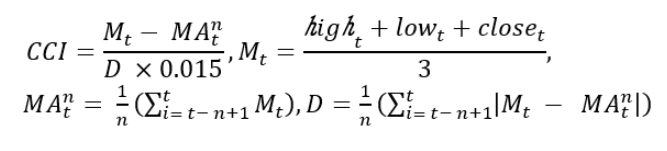

<br>

**해석 방법**

- CCI 값이 0이면 현재 주가가 이동 평균선과 일치한다는 뜻

- CCI 값이 +이면 상승추세, -이면 하락추세이다. 

- CCI 값이 클수록 추세의 강도가 강하고, 작을수록 추세의 강도가 약하다.

- CCI의 절댓값이 100 이상으로 크다는 것은 가격이 급변하였다는 것을 의미한다. (과매수/과매도 구간)


<br>

**[참고]**  

-[[주식투자] Chart 보조 지표 CCI 란?](https://designyourlifestyle.tistory.com/entry/%EC%A3%BC%EC%8B%9D%ED%88%AC%EC%9E%90-Chart-%EB%B3%B4%EC%A1%B0-%EC%A7%80%ED%91%9C-CCI-%EB%9E%80)  

-[주식용어 독파 [25] CCI의 의미와 실전 활용법](https://dipsy-encyclopedia.tistory.com/62)

<br>
<br>

## (2) CCI를 활용한 주가데이터 필터링 
본 연구에서는 앞서 살펴본 보조지표 CCI의 범위를 3가지 구간으로 나누어 데이터를 필터링 합니다. 이 때, **이동평균선**으로부터 근접한 **1) 중립구간**, 극단적으로 떨어진 **2) 과열구간/과매수구간** 과 **3) 침체 구간/과매도구간**으로 나눕니다.   


나누는 CCI의 구체적인 구간은 다음과 같다.  
**`1) 중립구간`** - CCI : (-20, 20)   
**`2) 과열구간`** - CCI : (100, $\infty$)   
**`3) 침체 구간`** - CCI : (-$\infty$,-100)   

- `스케일링 (div-prev_close)` + `CCI 구간 필터링` 데이터셋 생성 함수 

In [9]:
def make_dataset_cci(trading, cci_d='_', cci_u='_', train=True):
    from sklearn.preprocessing import MinMaxScaler
    
    col_price = ['Open', 'High', 'Low', 'Close', 'trading_value', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_etc = ['Change', 'Volume', 'MFI', 'ADI', 'OBV',
           'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
           'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
           'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
           'WR', 'AO', 'ROC', 'PPO', 'PVO']
    
    # 종목코드 불러오기 
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
        
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    temp_cci_d, temp_cci_u = cci_d, cci_u # 🌟 초기 cci 범위 저장 
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        if train:
            sql_query = '''
                        SELECT *
                        FROM stock_{}
                        WHERE Date BETWEEN '2017-01-01' AND '2020-12-31'
                        '''.format(code)
        else: 
            sql_query = '''
                        SELECT *
                        FROM stock_{}
                        WHERE Date BETWEEN '2021-01-01' AND '2021-12-31'
                        '''.format(code)
            
        
        stock = pd.read_sql(sql = sql_query, con = db_dsml) 
        stock['PrevClose'] = stock['Close'].shift(1) # 전 날 종가 컬럼 추가
        stock.dropna(inplace=True)
        stock = stock.reset_index(drop=True)
        stock['trading_value'] = stock['Close'] * stock['Volume']
        lst_stock = stock.values.tolist()

        if temp_cci_d == '_': 
            cci_d = stock['CCI'].min()
        if temp_cci_u == '_':
            cci_u = stock['CCI'].max()    
        
        # scaling
        # 1) 가격 관련 컬럼 
        df_price = stock[col_price]
        df_price_scaled = df_price.apply(lambda x: x / stock['PrevClose'])
        
        # 2) 나머지 컬럼 
        df_etc = stock[col_etc]
        
        df_scaled = pd.concat([df_price_scaled, df_etc], axis=1)
        lst_stock_scaled = df_scaled.values.tolist()

        
        for idx, row in enumerate(lst_stock): 
            date, trading_value, cci_ = row[0].date().strftime("%Y-%m-%d"), row[-1], row[40]
            # 🌟 cci 조건 설정 
            if (trading_value >= trading) & ((cci_ >= cci_d) & (cci_ <= cci_u)):
                if (idx < 9): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                sub_stock = lst_stock_scaled[idx-9:idx+1] 

                # 10일간의 데이터 
                lst_result = []
                for row2 in sub_stock:               
                    lst_result += row2

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return np.array(lst_X), np.array(lst_Y), np.array(lst_code_date) 

<br>

### 1) 중립구간 CCI : (-20, 20)
중립구간에서 데이터셋의 개수는 train: 123321, test:36885 개로, 세 구간 중 가장 적은 데이터셋의 개수가 나왔다. 정확도는 가장 높지만, auc score는 미미한 결과를 보였다. 

In [3]:
trainX_1, trainY_1, lst_code_date_1 = make_dataset_cci(trading=100000000, cci_d=-20, cci_u=20, train=True)
testX_1, testY_1, lst_code_date_test_1 = make_dataset_cci(trading=100000000, cci_d=-20, cci_u=20, train=False)

100%|███████████████████████████████████████████████████████████████████████| 1561/1561 [00:42<00:00, 36.60it/s]


In [4]:
print('train dataset: ', trainX_1.shape, trainY_1.shape)
print('test dataset: ', testX_1.shape, testY_1.shape)

train dataset:  (123321, 560) (123321,)
test dataset:  (36885, 560) (36885,)


In [5]:
from xgboost import XGBClassifier
xgb_1 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) 

xgb_1.fit(trainX_1, trainY_1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=40, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

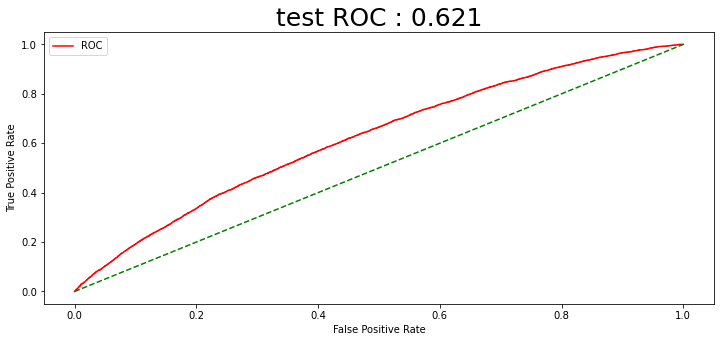

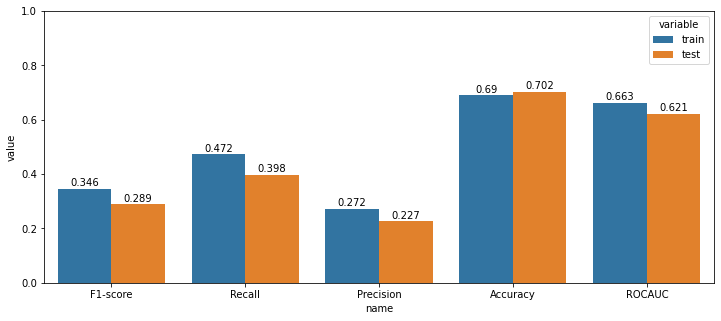

In [6]:
sf.plot_evauate(trainX_1, trainY_1, testX_1, testY_1, xgb_1)

<br>

### 2) 과열구간/과매수구간 CCI : (100, $\infty$)
침체구간에서 데이터셋의 개수는 train: 256399, test:64768 개로, 꽤 많은 데이터셋의 개수가 나왔다. 세 구간 중 가장 낮은 분류 성능을 보였다. 

In [16]:
trainX_2, trainY_2, lst_code_date_2 = make_dataset_cci(trading=100000000, cci_d=100, train=True)
testX_2, testY_2, lst_code_date_test_2 = make_dataset_cci(trading=100000000, cci_d=100, train=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:42<00:00, 36.67it/s]


In [17]:
print('train dataset: ', trainX_2.shape, trainY_2.shape)
print('test dataset: ', testX_2.shape, testY_2.shape)

train dataset:  (256399, 560) (256399,)
test dataset:  (64768, 560) (64768,)


In [18]:
from xgboost import XGBClassifier
xgb_2 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) 

xgb_2.fit(trainX_2, trainY_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=40, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

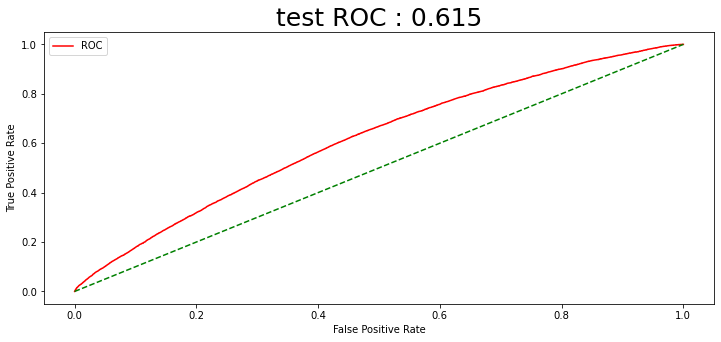

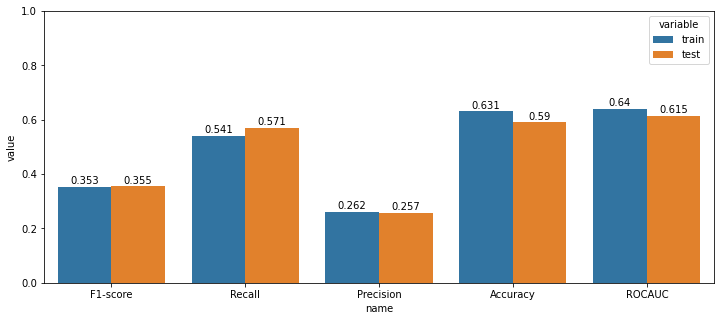

In [19]:
sf.plot_evauate(trainX_2, trainY_2, testX_2, testY_2, xgb_2)

<br>

### 3) 침체구간/과매도구간 CCI : (-$\infty$, -100)
침체구간에서 데이터셋의 개수는 train: 269977, test:73435 개로 가장 많은 데이터의 개수가 나왔으며, auc score를 봤을 때, 가장 높은 분류 성능을 보였다.

In [20]:
trainX_3, trainY_3, lst_code_date_3 = make_dataset_cci(trading=100000000, cci_u=-100, train=True)
testX_3, testY_3, lst_code_date_test_3 = make_dataset_cci(trading=100000000, cci_u=-100, train=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:43<00:00, 36.16it/s]


In [21]:
print('train dataset: ', trainX_3.shape, trainY_3.shape)
print('test dataset: ', testX_3.shape, testY_3.shape)

train dataset:  (269977, 560) (269977,)
test dataset:  (73435, 560) (73435,)


In [22]:
from xgboost import XGBClassifier
xgb_3 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) 

xgb_3.fit(trainX_3, trainY_3)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=40, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

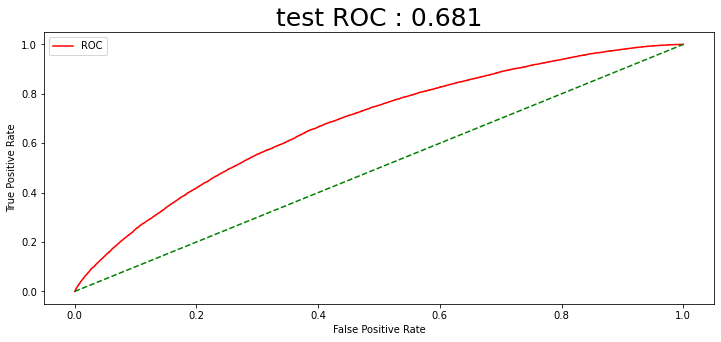

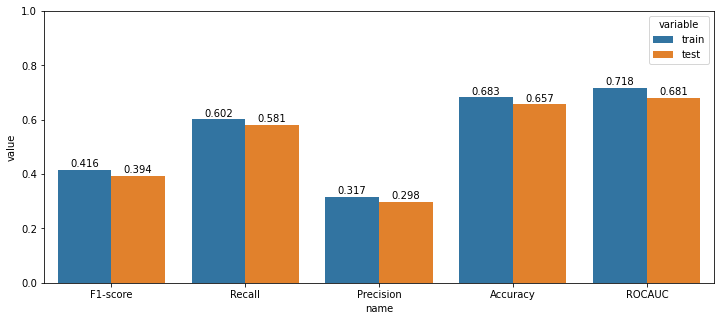

In [23]:
sf.plot_evauate(trainX_3, trainY_3, testX_3, testY_3, xgb_3)

- 데이터셋 저장   

각 학습, 시험 데이터셋과 XGBoost 모델을 pickle 파일로 저장한다. 

In [24]:
#collapse-hide
import pickle 
dic_dataset_model = {'CCI -20~20': [trainX_1, trainY_1, testX_1, testY_1, lst_code_date_1, lst_code_date_test_1, xgb_1],
                'CCI 100~': [trainX_2, trainY_2, testX_2, testY_2, lst_code_date_2, lst_code_date_test_2, xgb_2],
                'CCI ~-100': [trainX_3, trainY_3, testX_3, testY_3, lst_code_date_3, lst_code_date_test_3, xgb_3]}

with open('dataset_cci_filtering.pickle', 'wb') as handle:
    pickle.dump(dic_dataset_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

<br>

다음 글에서는 위에서 CCI 구간별로 학습한 XGBoost 모델에 `XAI` 기법 중 하나인 `SHAP value`를 적용하여 데이터를 변환하고, 각 구간마다 `summary plot`을 그려보며 중요한 특성과 그에 대한 해석을 진행하도록 한다. 